In [146]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from PIL import Image
import time

The goal of this dataset should be:
- Autoencoder should be able to reconstruct normal images accurately
- Normal images should have low reconstruction error
- Tumor images should have high reconstruction error since model wasn't trained on them
- The threshold should be able to classify images as anomalous if its loss is higher than threshold

In [147]:
# Check if GPU is enabled
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Inspect Dataset

In [148]:
# Download dataset from kaggle
# Link: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
# path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

In [149]:
# Path for dataset
DATASET_PATH = Path("archive/Dataset")

# Define path for healthy and tumor folders
MRI_PATH = DATASET_PATH / "Brain Tumor MRI Images"
MRI_HEALTHY_PATH = MRI_PATH / "Healthy"
MRI_TUMOR_PATH = MRI_PATH / "Tumor"

In [150]:
# Inspect how many images are in each folder
print(f'Number of Healthy Brain MRI Scans: {len(list(MRI_HEALTHY_PATH.glob("*")))}')
print(f'Number of Tumor Brain MRI Scans: {len(list(MRI_TUMOR_PATH.glob("*")))}')

Number of Healthy Brain MRI Scans: 2000
Number of Tumor Brain MRI Scans: 3000


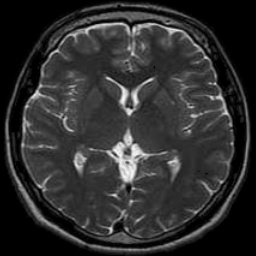

In [151]:
# Show random healthy brain MRI image
healthy_images = list(MRI_HEALTHY_PATH.glob("*"))
rand_index_healthy = np.random.randint(len(healthy_images))

Image.open(healthy_images[rand_index_healthy])

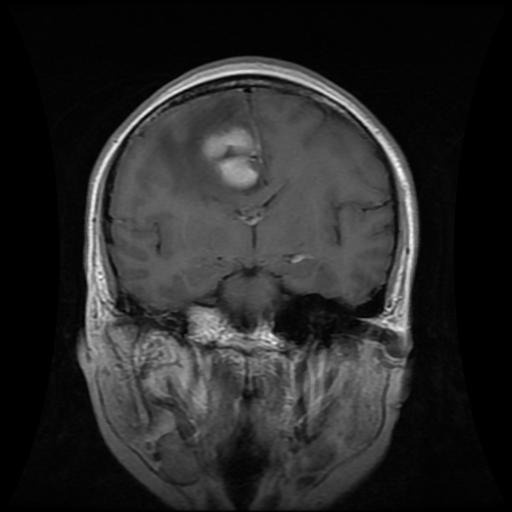

In [152]:
# Show random brain tumor MRI image
tumor_images = list(MRI_TUMOR_PATH.glob("*"))
rand_index_tumor = np.random.randint(len(tumor_images))

Image.open(tumor_images[rand_index_tumor])

### Preprocess Images

In [153]:
# Normalizes pixel values of an image between [0, 1]
def normalize(image):
    return image / 255.0

In [154]:
# Resizes image based on given height and width dimension
def resize(input_image, height, width):
    return tf.image.resize(
        images = input_image,
        size = [height, width],
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

In [155]:
def preprocess_img(img_path, height=128, width=128):
    # Read file from file path
    image = tf.io.read_file(img_path)

    # https://www.tensorflow.org/api_docs/python/tf/io/decode_image
    # "Note: decode_gif returns a 4-D array [num_frames, height, width, 3], as opposed to decode_bmp, 
    # decode_jpeg and decode_png, which return 3-D arrays [height, width, num_channels]."
    # set the expand_animations argument of this function to False, in which case the op will return 3-dimensional tensors 
    # and will truncate animated GIF files to the first frame.
    # Set channels to 1 so that every image is converted to grayscale
    image = tf.io.decode_image(image, expand_animations=False, channels=1)

    # Convert image to tensor
    image = tf.cast(image, dtype="float32")

    # Resize image
    image = resize(image, height, width)

    # Normalize pixels in image
    image = normalize(image)
    
    # Model expects data and labels; return image twice to fit model requirement
    return image, image

In [156]:
def show_image(image):
    # Display pixel value range
    print(f'[{np.min(image)}, {np.max(image)}]')

    # Display image shape
    print(f'Image shape: {image.shape}')
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # imshow shows images in color; specify "gray"
    plt.imshow(image, cmap="gray")
    plt.show()

[0.05882352963089943, 1.0]
Image shape: (128, 128, 1)


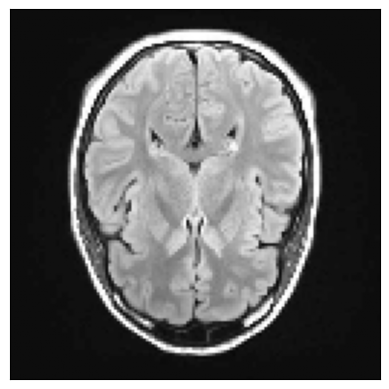

In [157]:
# Pass random image into preprocess function
rand_index_healthy = np.random.randint(len(healthy_images))
img, _ = preprocess_img(str(healthy_images[rand_index_healthy]))

show_image(img)

[0.0, 0.8666666746139526]
Image shape: (128, 128, 1)


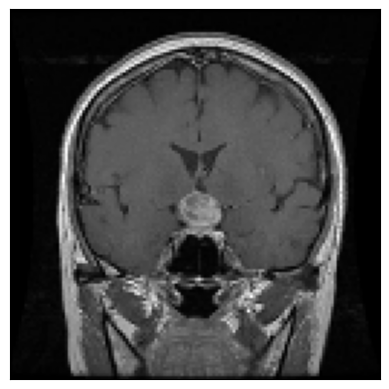

In [158]:
rand_index_tumor = np.random.randint(len(tumor_images))
img, _ = preprocess_img(str(tumor_images[rand_index_tumor]))

show_image(img)

### Build Train, Test, and Validation Dataset

In [159]:
BATCH_SIZE = 64
BUFFER_SIZE = len(healthy_images)

In [160]:
healthy_dataset = tf.data.Dataset.list_files(str(MRI_HEALTHY_PATH / "*"))

healthy_dataset = healthy_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
healthy_dataset = healthy_dataset.shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)

tumor_dataset = tf.data.Dataset.list_files(str(MRI_TUMOR_PATH / "*"))

# No shuffling for tumor dataset as this will be test dataset
tumor_dataset = tumor_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
tumor_dataset = tumor_dataset.prefetch(tf.data.AUTOTUNE)

In [161]:
# Link: https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test
# Split dataset into sections

# Testing data that comprises only of normal images to establish threshold value (200 images)
# 400 images are taken because half of it will be used for validation
normal_test_data = healthy_dataset.take(400)

# Train data that comprises only of normal images (1600 images)
normal_train_data = healthy_dataset.skip(400)

# 200 images for validation for creating threshold; the rest (200) for test
normal_valid_data = normal_test_data.take(200)
normal_test_data = normal_test_data.skip(200)

# Combine images from normal and tumor dataset to form one validation dataset (200 + 200)
tumor_valid_data = tumor_dataset.take(200)
valid_data = normal_valid_data.concatenate(tumor_valid_data)

# Set aside 200 images from training data for establishing threshold-value
normal_threshold_data = normal_train_data.take(200)
normal_train_data = normal_train_data.skip(200)

# Take 200 images from tumor dataset for testing; the rest is saved for evaluating threshold on just tumor images
tumor_dataset = tumor_dataset.skip(200)
tumor_test_data = tumor_dataset.take(200)
tumor_dataset = tumor_dataset.skip(200)

# Testing data that has a mix of both normal and tumor images to evaluate threshold
test_dataset = normal_test_data.concatenate(tumor_test_data)

# Ensure that split happened correctly for each set
print(f'Normal train data size: {len(normal_train_data)}')
print(f'Normal test data size: {len(normal_test_data)}')
print(f'Normal valid data size: {len(normal_valid_data)}')
print(f'Normal threshold data size: {len(normal_threshold_data)}')
print(f'Tumor dataset size: {len(tumor_dataset)}')
print(f'Tumor valid data size: {len(tumor_valid_data)}')
print(f'Tumor test data size: {len(tumor_test_data)}')
print(f'Validation data size: {len(valid_data)}')
print(f'Test dataset size: {len(test_dataset)}')

Normal train data size: 1400
Normal test data size: 200
Normal valid data size: 200
Normal threshold data size: 200
Tumor dataset size: 2600
Tumor valid data size: 200
Tumor test data size: 200
Validation data size: 400
Test dataset size: 400


In [162]:
normal_train_data = normal_train_data.batch(BATCH_SIZE)
normal_threshold_data = normal_threshold_data.batch(BATCH_SIZE)
normal_test_data = normal_test_data.batch(BATCH_SIZE)

# Shuffle validation set to ensure model doesn't learn neighboring patterns
valid_data = valid_data.shuffle(len(valid_data)).batch(BATCH_SIZE)

tumor_dataset = tumor_dataset.batch(BATCH_SIZE)

# Do not shuffle test dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

### Initialize Convolutional Autoencoder Model

In [339]:
class AnomalyCAE(Model):
    def __init__(self, latent_dim):
        super(AnomalyCAE, self).__init__()
        
        # Downsampling with CNN
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(128, 128, 1)),
            layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same"),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same"),
            layers.ReLU(),
            layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same"),
            layers.ReLU(),
            layers.Flatten(),
            layers.Dense(latent_dim * 2),
            layers.Dense(latent_dim) # no activation to keep latent representations
        ])

        # Upsampling with CNN
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=16*16*128, activation="relu"),
            layers.Reshape(target_shape=(16, 16, 128)),
            layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            # Filter must match color channel of original input
            layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(2, 2), padding="same"),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

latent_dim = 128
autoencoder = AnomalyCAE(latent_dim)

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 re_lu_27 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 re_lu_28 (ReLU)             (None, 32, 32, 64)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 re_lu_29 (ReLU)             (None, 16, 16, 128)       0         
                                                                 
 flatten_17 (Flatten)        (None, 32768)           

In [341]:
autoencoder.decoder.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32768)             4227072   
                                                                 
 reshape_17 (Reshape)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_53 (Conv2D  (None, 32, 32, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_54 (Conv2D  (None, 64, 64, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 128, 128, 1)      257       
 Transpose)                                                      
                                                     

### Train Autoencoder Model

In [342]:
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError())

In [343]:
cae_history = autoencoder.fit(
    normal_train_data,
    epochs=30,
    validation_data=valid_data,
    shuffle=True
)
  

Epoch 1/30
22/22 [==============================] - 3s 86ms/step - loss: 0.0672 - val_loss: 0.0378
Epoch 2/30
22/22 [==============================] - 3s 90ms/step - loss: 0.0298 - val_loss: 0.0247
Epoch 3/30
22/22 [==============================] - 3s 85ms/step - loss: 0.0266 - val_loss: 0.0244
Epoch 4/30
22/22 [==============================] - 2s 73ms/step - loss: 0.0255 - val_loss: 0.0210
Epoch 5/30
22/22 [==============================] - 2s 73ms/step - loss: 0.0229 - val_loss: 0.0191
Epoch 6/30
22/22 [==============================] - 2s 72ms/step - loss: 0.0222 - val_loss: 0.0204
Epoch 7/30
22/22 [==============================] - 2s 72ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 8/30
22/22 [==============================] - 2s 73ms/step - loss: 0.0198 - val_loss: 0.0181
Epoch 9/30
22/22 [==============================] - 2s 72ms/step - loss: 0.0194 - val_loss: 0.0181
Epoch 10/30
22/22 [==============================] - 2s 73ms/step - loss: 0.0187 - val_loss: 0.0171
Epoch 11/

### Plot Results

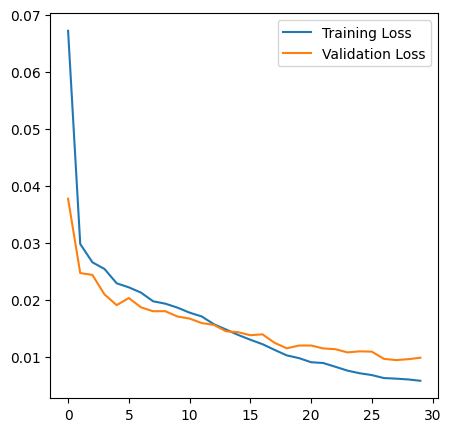

In [344]:
fig = plt.figure(figsize=(5, 5))
plt.plot(cae_history.history["loss"], label="Training Loss")
plt.plot(cae_history.history["val_loss"], label="Validation Loss")
plt.legend()

plt.show()

In [345]:
def test_single_img(data):
    # Retrieve only one batch from dataset
    for batch in data.take(1):
        # Get first image from batch
        image = batch[0][0]

        # Insert batch dimension into image: (1, 128, 128, 1)
        encoded_data = autoencoder.encoder(tf.expand_dims(image, axis=0)).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()

        fig = plt.figure(figsize=(7, 7))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title("Input Image")

        # Remove batch dimension for visualization
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_data[0].squeeze(), cmap="gray")
        plt.title("Reconstructed Image")

        plt.show()

Healthy images that have been reconstructed should look similar to the original input because the model was trained on healthy images. The reconstructed image should have noise.

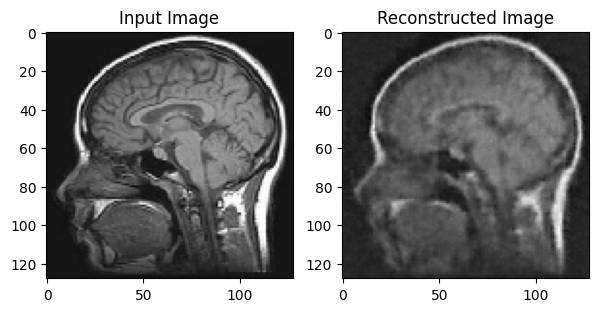

In [346]:
test_single_img(normal_train_data)

Tumorous images should have a tougher time being recreated by the autoencoder due to tumorous images not being used for training. These images should be unrecognizable.

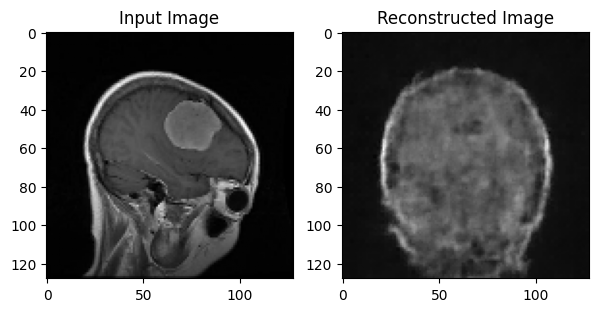

In [347]:
test_single_img(tumor_dataset)

### Test Model

In [348]:
def prediction(data):
    total_loss = []

    for batch in data.take(len(data)):
        reconstruction = autoencoder.predict(batch[0], verbose=0)
        train_loss = tf.keras.losses.mse(reconstruction, batch[0])

        # train_loss computes MSE for each pixel in an image so use reduce_mean()
        # to average over all pixels across all dimensions into a single value for each image 
        train_loss = tf.reduce_mean(train_loss, axis=(1, 2))

        # Append list into another list but keep it 1D
        total_loss.extend(train_loss)
    
    return total_loss

In [349]:
def show_distribution(loss, threshold=0, bins=60):
    fig = plt.figure(figsize=(7, 7))
    plt.hist(loss, bins=bins)
    plt.xlabel("loss")
    plt.ylabel("No of examples")

    if threshold > 0:
        plt.axvline(threshold, color='r', linestyle="--", label="threshold")
    
    plt.legend()
    plt.show()

C:\Users\tommy\AppData\Local\Temp\ipykernel_1752\403924601.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


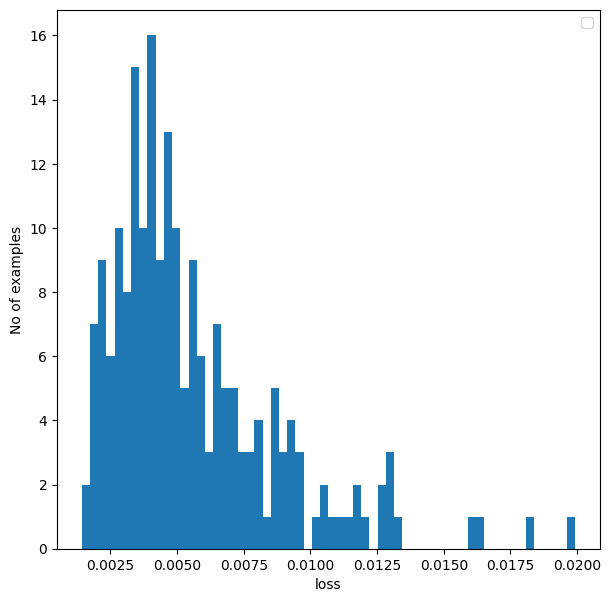

In [350]:
total_normal_loss = prediction(normal_threshold_data)
show_distribution(total_normal_loss)

### Set Threshold

In [351]:
# Establish threshold 
threshold = np.mean(total_normal_loss) + np.std(total_normal_loss)
print(f'Threshold: {threshold}')

Threshold: 0.008816475048661232


### Compare Model Prediction to Threshold

In [352]:
# Returns a list of booleans on if each element in total_loss is less than the threshold
def get_predictions(total_loss, threshold, isNormal=True):
    if isNormal:
        # Loss less than the threshold means that it is normal
        return tf.math.less(total_loss, threshold)

    return tf.math.greater(total_loss, threshold)

In [353]:
# Display accuracy, precision, and recall score between model predictions and truth labels
def print_stats(predictions, labels):
    print(f'Accuracy: {accuracy_score(labels, predictions):.2f}')
    print(f'Precision: {precision_score(labels, predictions):.2f}')
    print(f'Recall: {recall_score(labels, predictions):.2f}')

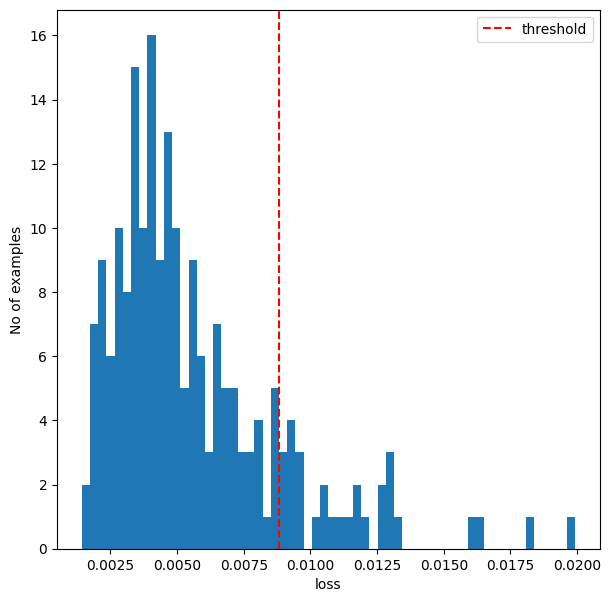

In [354]:
total_normal_test_loss = prediction(normal_test_data)

show_distribution(total_normal_loss, threshold)

Reconstruction error for anomalous images should be higher than reconstruction error for normal images. Autoencoder was trained purely on normal images.

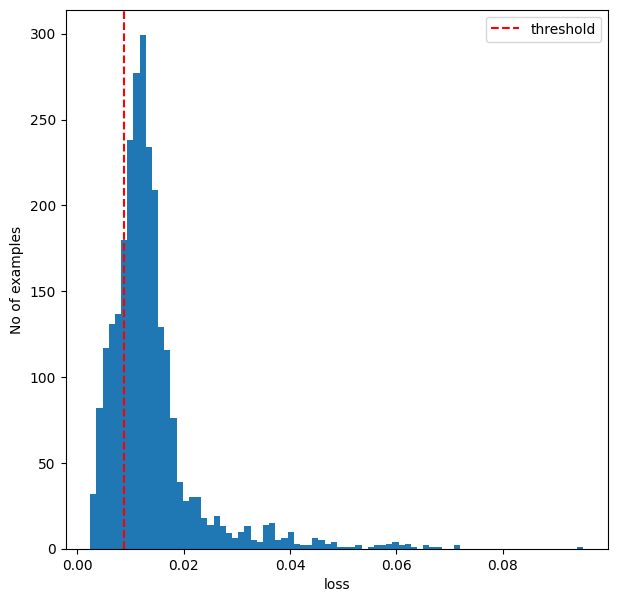

Accuracy: 0.77
Precision: 1.00
Recall: 0.77


In [355]:
total_tumor_test_loss = prediction(tumor_dataset)

tumor_test_predictions = get_predictions(total_tumor_test_loss, threshold, isNormal=False)

# Labels are all 0s because we ideally want our tumor test loss to be above the threshold
tumor_test_labels = [1 for i in range(len(total_tumor_test_loss))]

show_distribution(total_tumor_test_loss, threshold, bins=80)
print_stats(tumor_test_predictions, tumor_test_labels)

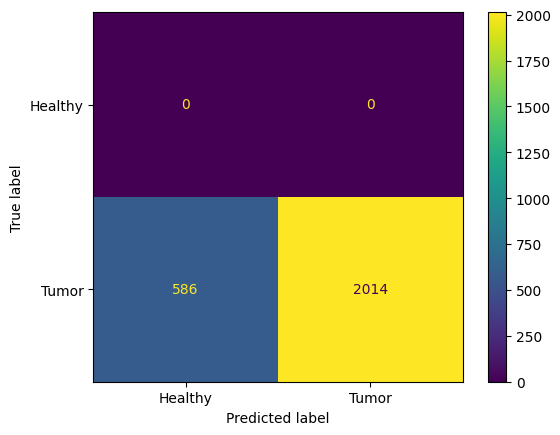

In [356]:
cm = confusion_matrix(tumor_test_labels, tumor_test_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])

cm_display.plot()

In [357]:
total_test_loss = prediction(test_dataset)

combined_test_predictions = get_predictions(total_test_loss, threshold)

# Because we are using tf.math.less, normal images get a 1 while abnormal get 0
# Test dataset is unshuffled; 1st half of dataset should be normal images and 2nd half is tumor images
combined_test_labels = [1 if i < len(total_test_loss) / 2 else 0 for i in range(len(total_test_loss))]

print_stats(combined_test_predictions, combined_test_labels)

Accuracy: 0.85
Precision: 0.81
Recall: 0.91


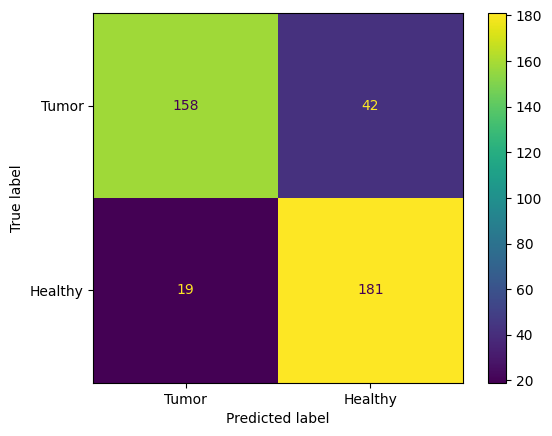

In [358]:
cm = confusion_matrix(combined_test_labels, combined_test_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Healthy"])

cm_display.plot()